# RCC Prediction Model (PEG_FUSION_0)

#### This script is intented to develop some approach using mahine learning models to predict future greenness of plants.
#### Input Features: 
##### 1. rcc_90 value of 20 days from last year : (t-10)th to (t+9)th day                          
##### 2. Weather variables ('radiation', 'max_temp', 'min_temp', 'precipitation’)
#### Target Variable: rcc_90
###### Current weather data extracted from Daymet.

#### Approach: Fuse multiple machine learning models to predict the value and standard deviation of the target variable. ML models used: Random Forest Regressor, ElasticNet, Extreme Gradient Boosting and K-Nearest Neighbor. 

In [1]:
# Importing all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
import pickle

In [2]:
# Importing the phenology-targets dataset from ecological forecasting website
url = "https://data.ecoforecast.org/targets/phenology/phenology-targets.csv.gz"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)
dataset

Shape of imported dataset:(40014, 6)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'rcc_90', 'gcc_sd', 'rcc_sd'], dtype='object')


time siteID   gcc_90   rcc_90    gcc_sd    rcc_sd
0      2016-01-29   BART      NaN      NaN       NaN       NaN
1      2016-01-30   BART      NaN      NaN       NaN       NaN
2      2016-01-31   BART      NaN      NaN       NaN       NaN
3      2016-02-01   BART      NaN      NaN       NaN       NaN
4      2016-02-02   BART      NaN      NaN       NaN       NaN
...           ...    ...      ...      ...       ...       ...
40009  2022-02-24   WOOD  0.33685  0.33339  0.000096  0.009207
40010  2022-02-25   WOOD  0.33656  0.33462  0.000096  0.009207
40011  2022-02-26   WOOD  0.33778  0.33765  0.000096  0.009207
40012  2022-02-27   WOOD  0.33803  0.34279  0.000096  0.009207
40013  2022-02-28   WOOD  0.33797  0.34779  0.000096  0.009207

[40014 rows x 6 columns]

In [3]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
#dataset = dataset.set_index("time")

site_list = dataset["siteID"].unique()
print("Sites:")
print(site_list)

Sites:
['BART' 'CLBJ' 'CPER' 'DELA' 'DSNY' 'GRSM' 'HARV' 'JORN' 'KONZ' 'MLBS'
 'OAES' 'ONAQ' 'SCBI' 'SERC' 'SRER' 'STEI' 'UKFS' 'WOOD']


In [5]:
url = "gcc_weather.csv"
weather_data = pd.read_csv(url)
print("Shape of imported dataset:" + str(weather_data.shape))
print("\nColumns of imported dataset:")
print(weather_data.columns)
weather_data.rename(columns = {'date':'time'}, inplace = True)
weather_data['time'] = pd.to_datetime(weather_data['time'])

Shape of imported dataset:(39852, 6)

Columns of imported dataset:
Index(['date', 'siteID', 'radiation', 'max_temp', 'min_temp', 'precip'], dtype='object')


In [6]:
# Merging weather data and phenology data
dataset = pd.merge(left = dataset, right = weather_data, how='outer', left_on=['time','siteID'], right_on=['time','siteID'])
dataset

time siteID   gcc_90   rcc_90    gcc_sd    rcc_sd  year  month  \
0     2016-01-29   BART      NaN      NaN       NaN       NaN  2016      1   
1     2016-01-30   BART      NaN      NaN       NaN       NaN  2016      1   
2     2016-01-31   BART      NaN      NaN       NaN       NaN  2016      1   
3     2016-02-01   BART      NaN      NaN       NaN       NaN  2016      2   
4     2016-02-02   BART      NaN      NaN       NaN       NaN  2016      2   
...          ...    ...      ...      ...       ...       ...   ...    ...   
40009 2022-02-24   WOOD  0.33685  0.33339  0.000096  0.009207  2022      2   
40010 2022-02-25   WOOD  0.33656  0.33462  0.000096  0.009207  2022      2   
40011 2022-02-26   WOOD  0.33778  0.33765  0.000096  0.009207  2022      2   
40012 2022-02-27   WOOD  0.33803  0.34279  0.000096  0.009207  2022      2   
40013 2022-02-28   WOOD  0.33797  0.34779  0.000096  0.009207  2022      2   

       day year_month  radiation  max_temp  min_temp  precip  
0       29     2016-1   8.591550      1.71    -10.12     0.0  
1       30     2016-1   6.506730      2.39     -5.04     0.0  
2       31     2016-1   8.554779      7.29     -4.20     0.0  
3        1     2016-2   9.190341     10.82     -2.76     0.0  
4        2     2016-2   7.378106      5.26     -3.59     0.0  
...    ...        ...        ...       ...       ...     ...  
40009   24     2022-2        NaN       NaN       NaN     NaN  
40010   25     2022-2        NaN       NaN       NaN     NaN  
40011   26     2022-2        NaN       NaN       NaN     NaN  
40012   27     2022-2        NaN       NaN       NaN     NaN  
40013   28     2022-2        NaN       NaN       NaN     NaN  

[40014 rows x 14 columns]

In [7]:
num_sites = len(site_list)
num_sites

18

In [8]:
# Selecting the required columns: siteID and gcc_90 and date related columns
gcc_data = dataset[["time", "year", "month", "day", "year_month", "siteID", "gcc_90", "radiation", "max_temp", "min_temp", "precip"]]
print("Shape of gcc_data:" + str(gcc_data.shape))

rcc_data = dataset[["time", "year", "month", "day", "year_month", "siteID", "rcc_90", "radiation", "max_temp", "min_temp", "precip"]]
print("Shape of rcc_data:" + str(rcc_data.shape))

#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
gcc_site_data = []
for i in range(0,num_sites):
    gcc_site_data.append(gcc_data_by_site.get_group(site_list[i]))
    
# Selecting the required columns: siteID and rcc_90 and date related columns    
rcc_data_by_site = rcc_data.groupby("siteID")
rcc_site_data = []
for i in range(0,num_sites):
    rcc_site_data.append(rcc_data_by_site.get_group(site_list[i]))

for i in range(0,num_sites):
    gcc_site_data[i].reset_index(inplace = True, drop = True)
    rcc_site_data[i].reset_index(inplace = True, drop = True)

Shape of gcc_data:(40014, 11)
Shape of rcc_data:(40014, 11)


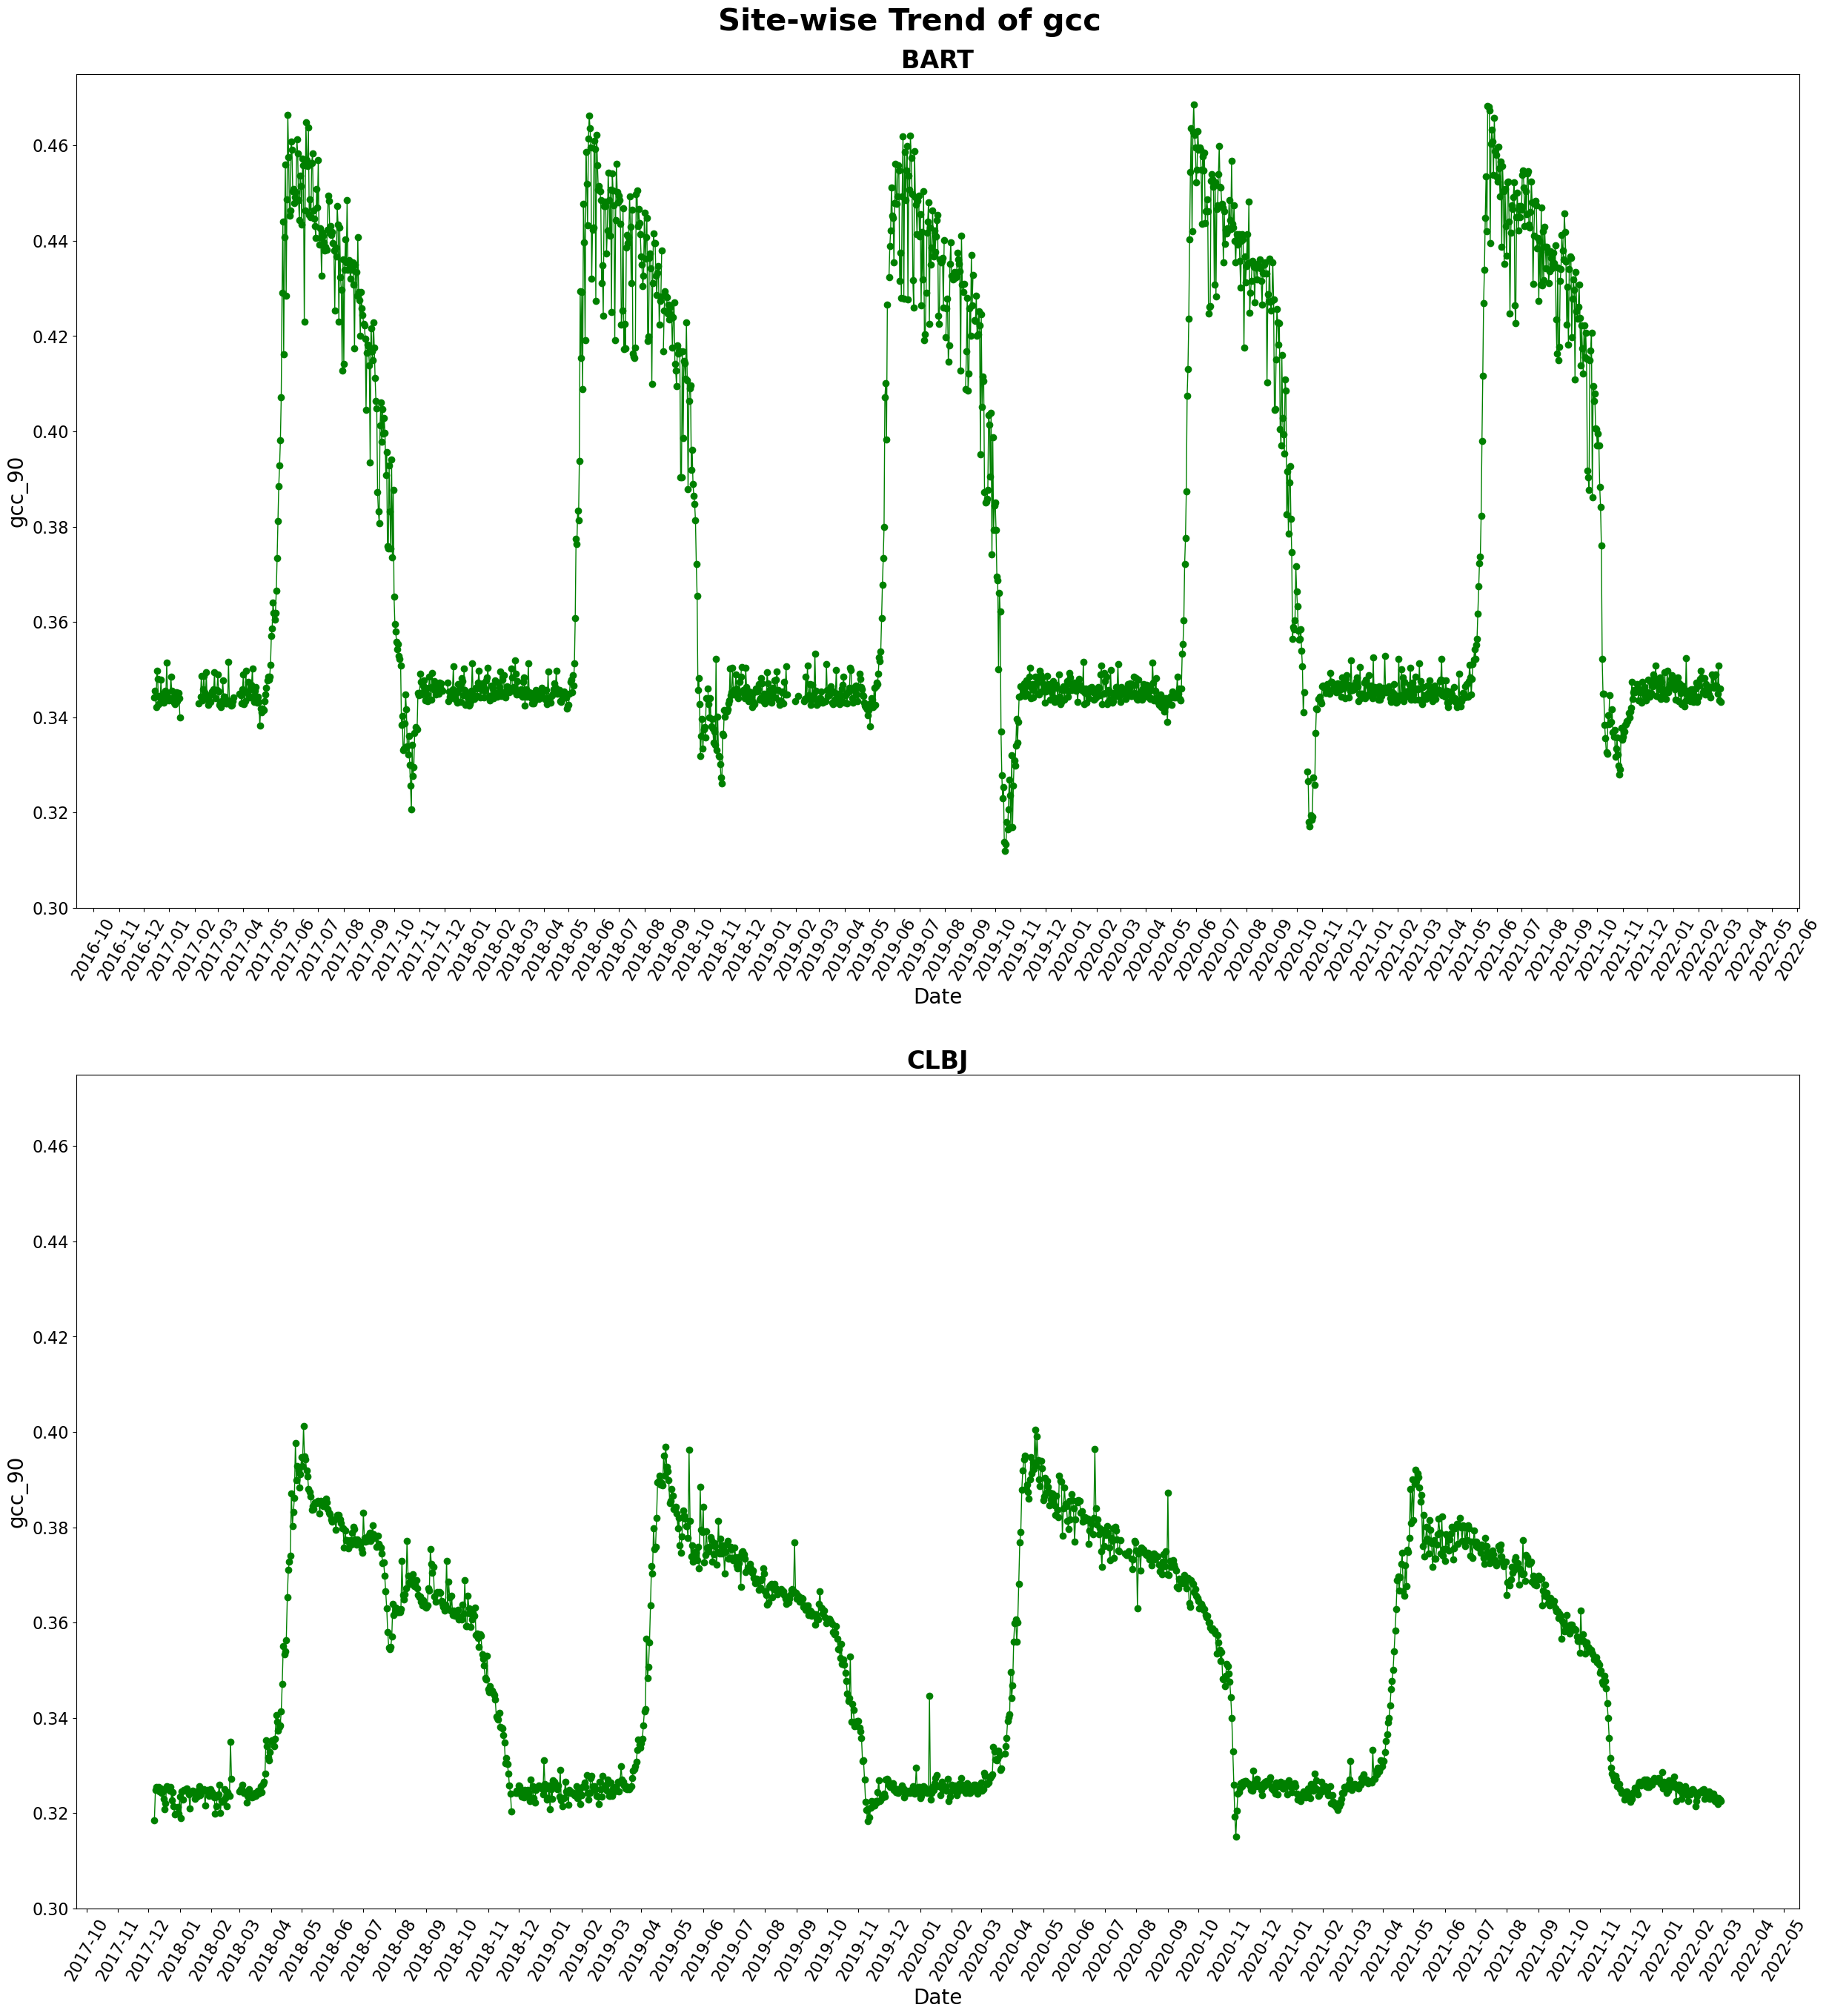

In [9]:
fig, ax = plt.subplots(2, 1, figsize = (30, 30), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of gcc", fontsize=30, fontweight='bold')

for k in range(0,2):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.475)
    ax[k].set_ylabel("gcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

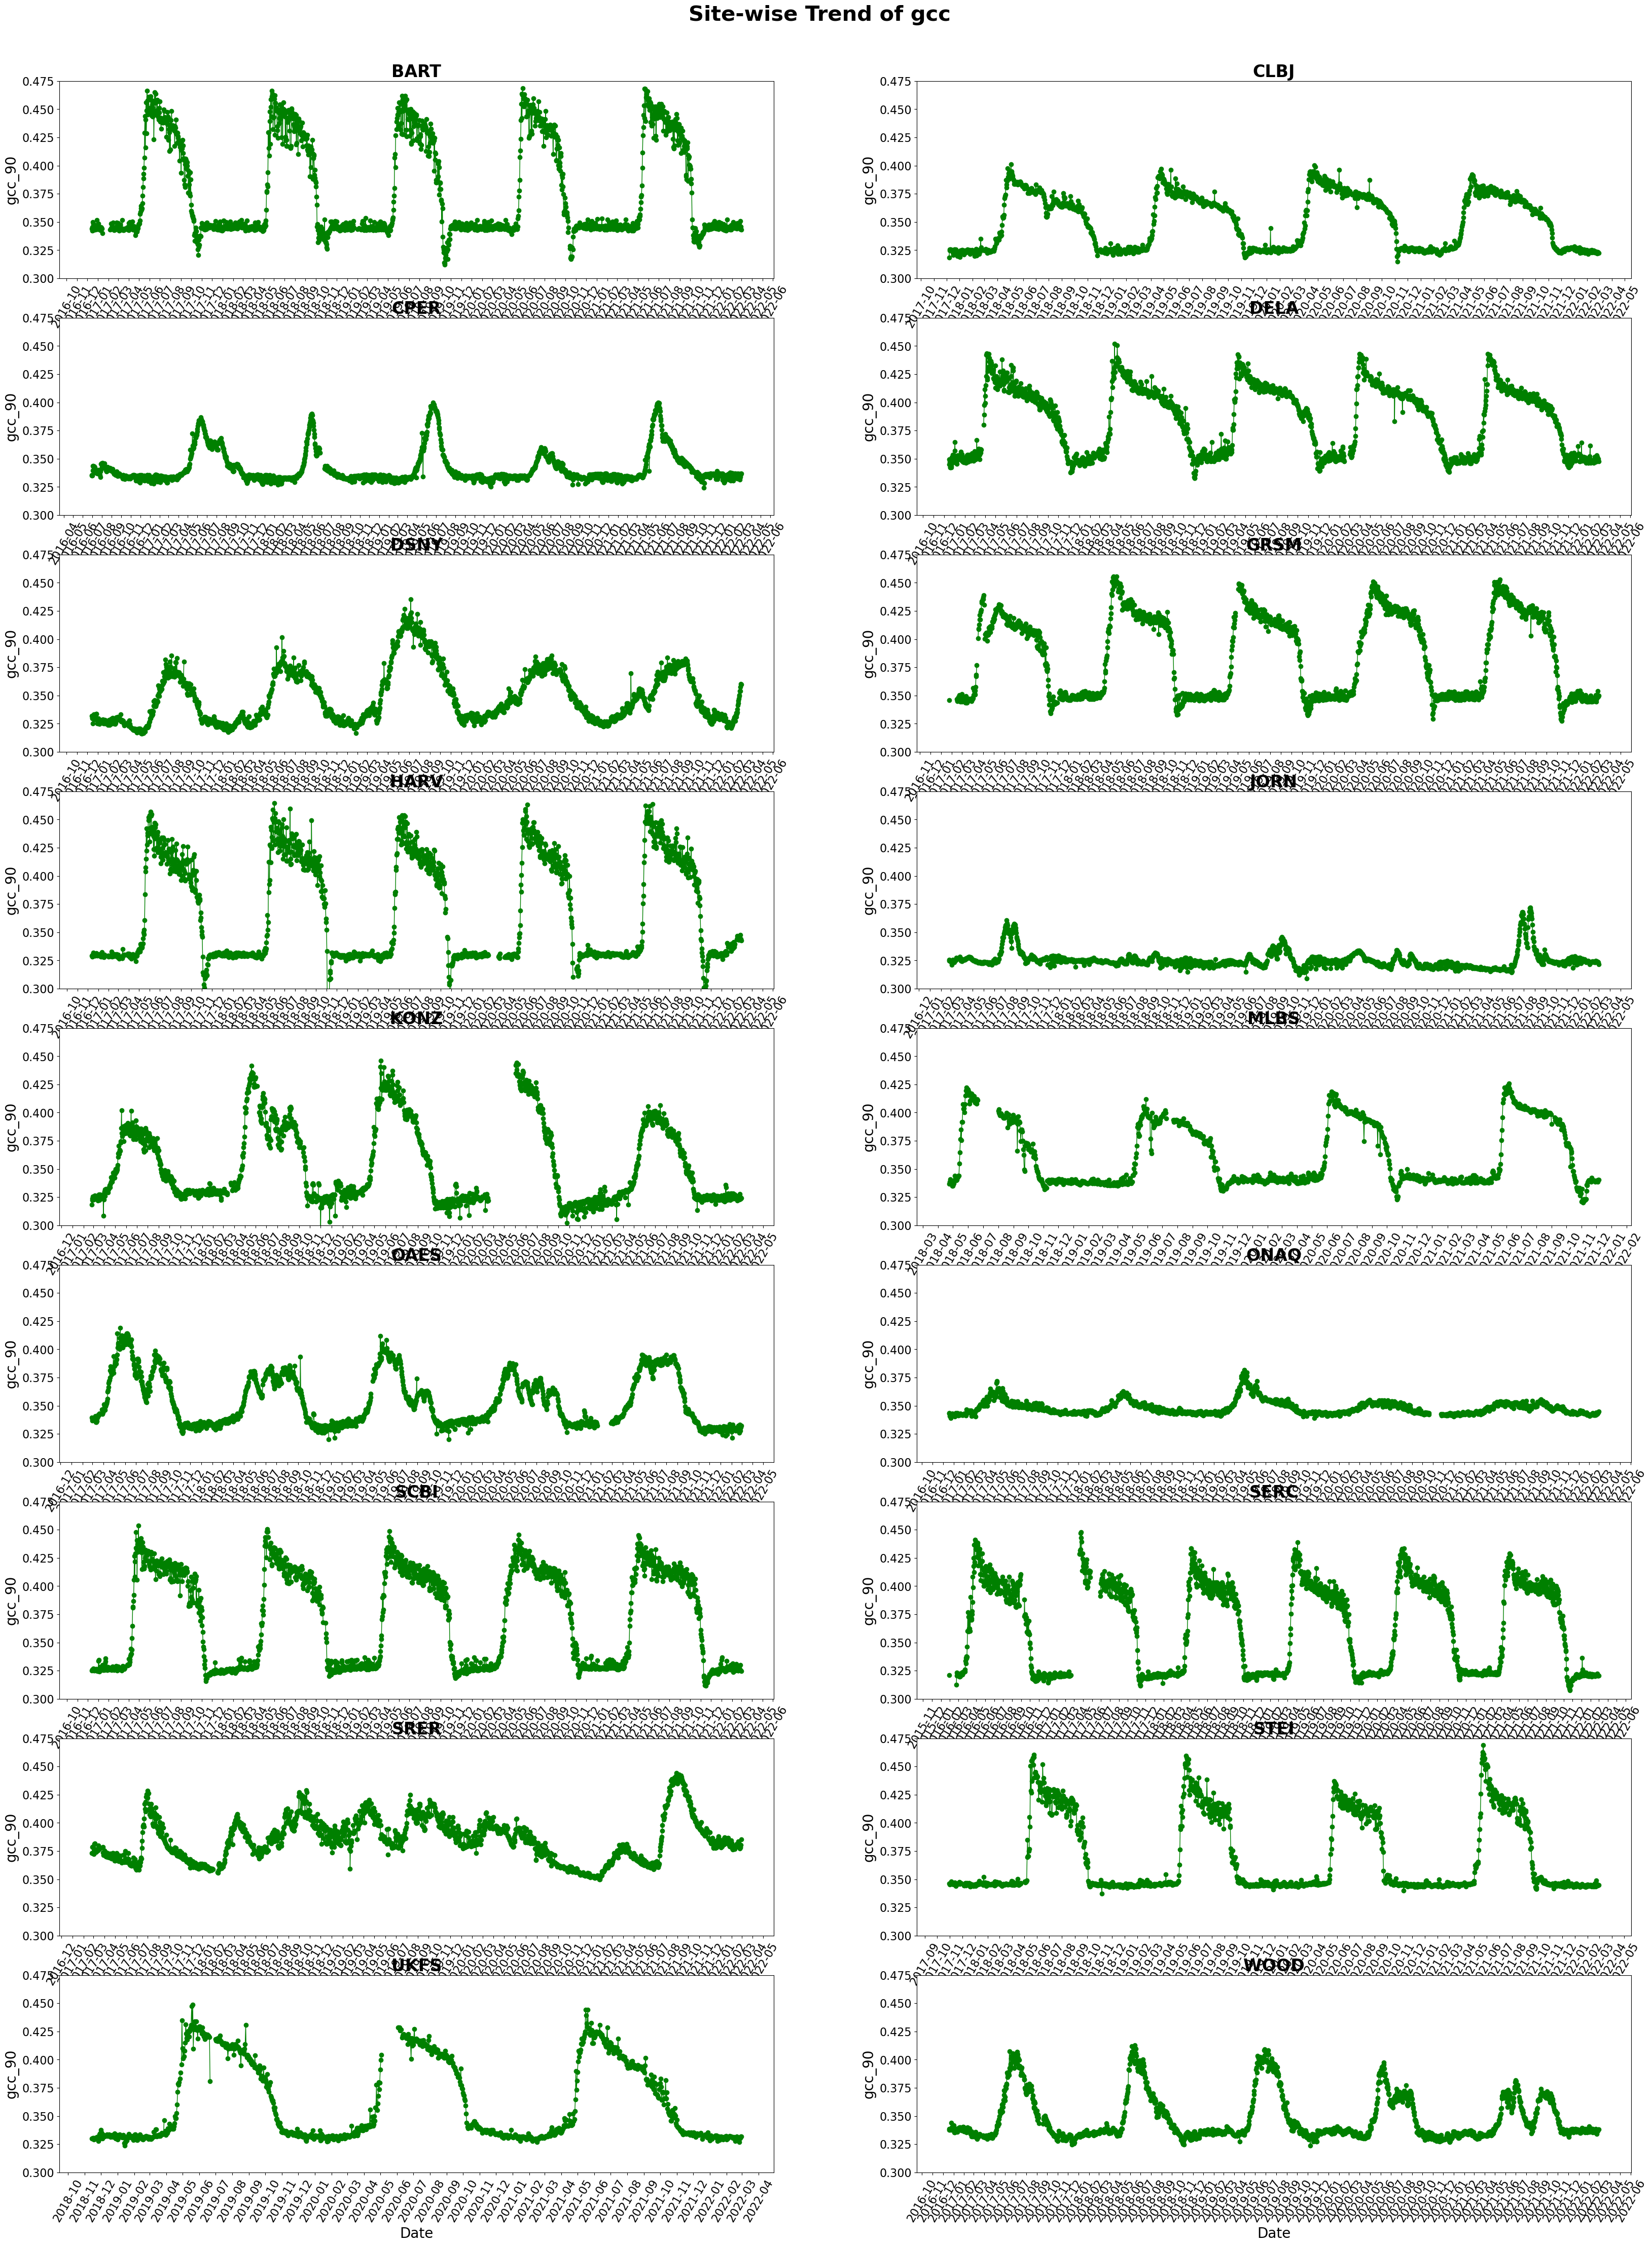

In [10]:
fig, ax = plt.subplots(9, 2, figsize = (40, 50), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of gcc", fontsize=30, fontweight='bold')

for k in range(0,num_sites):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.475)
    ax[k].set_ylabel("gcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

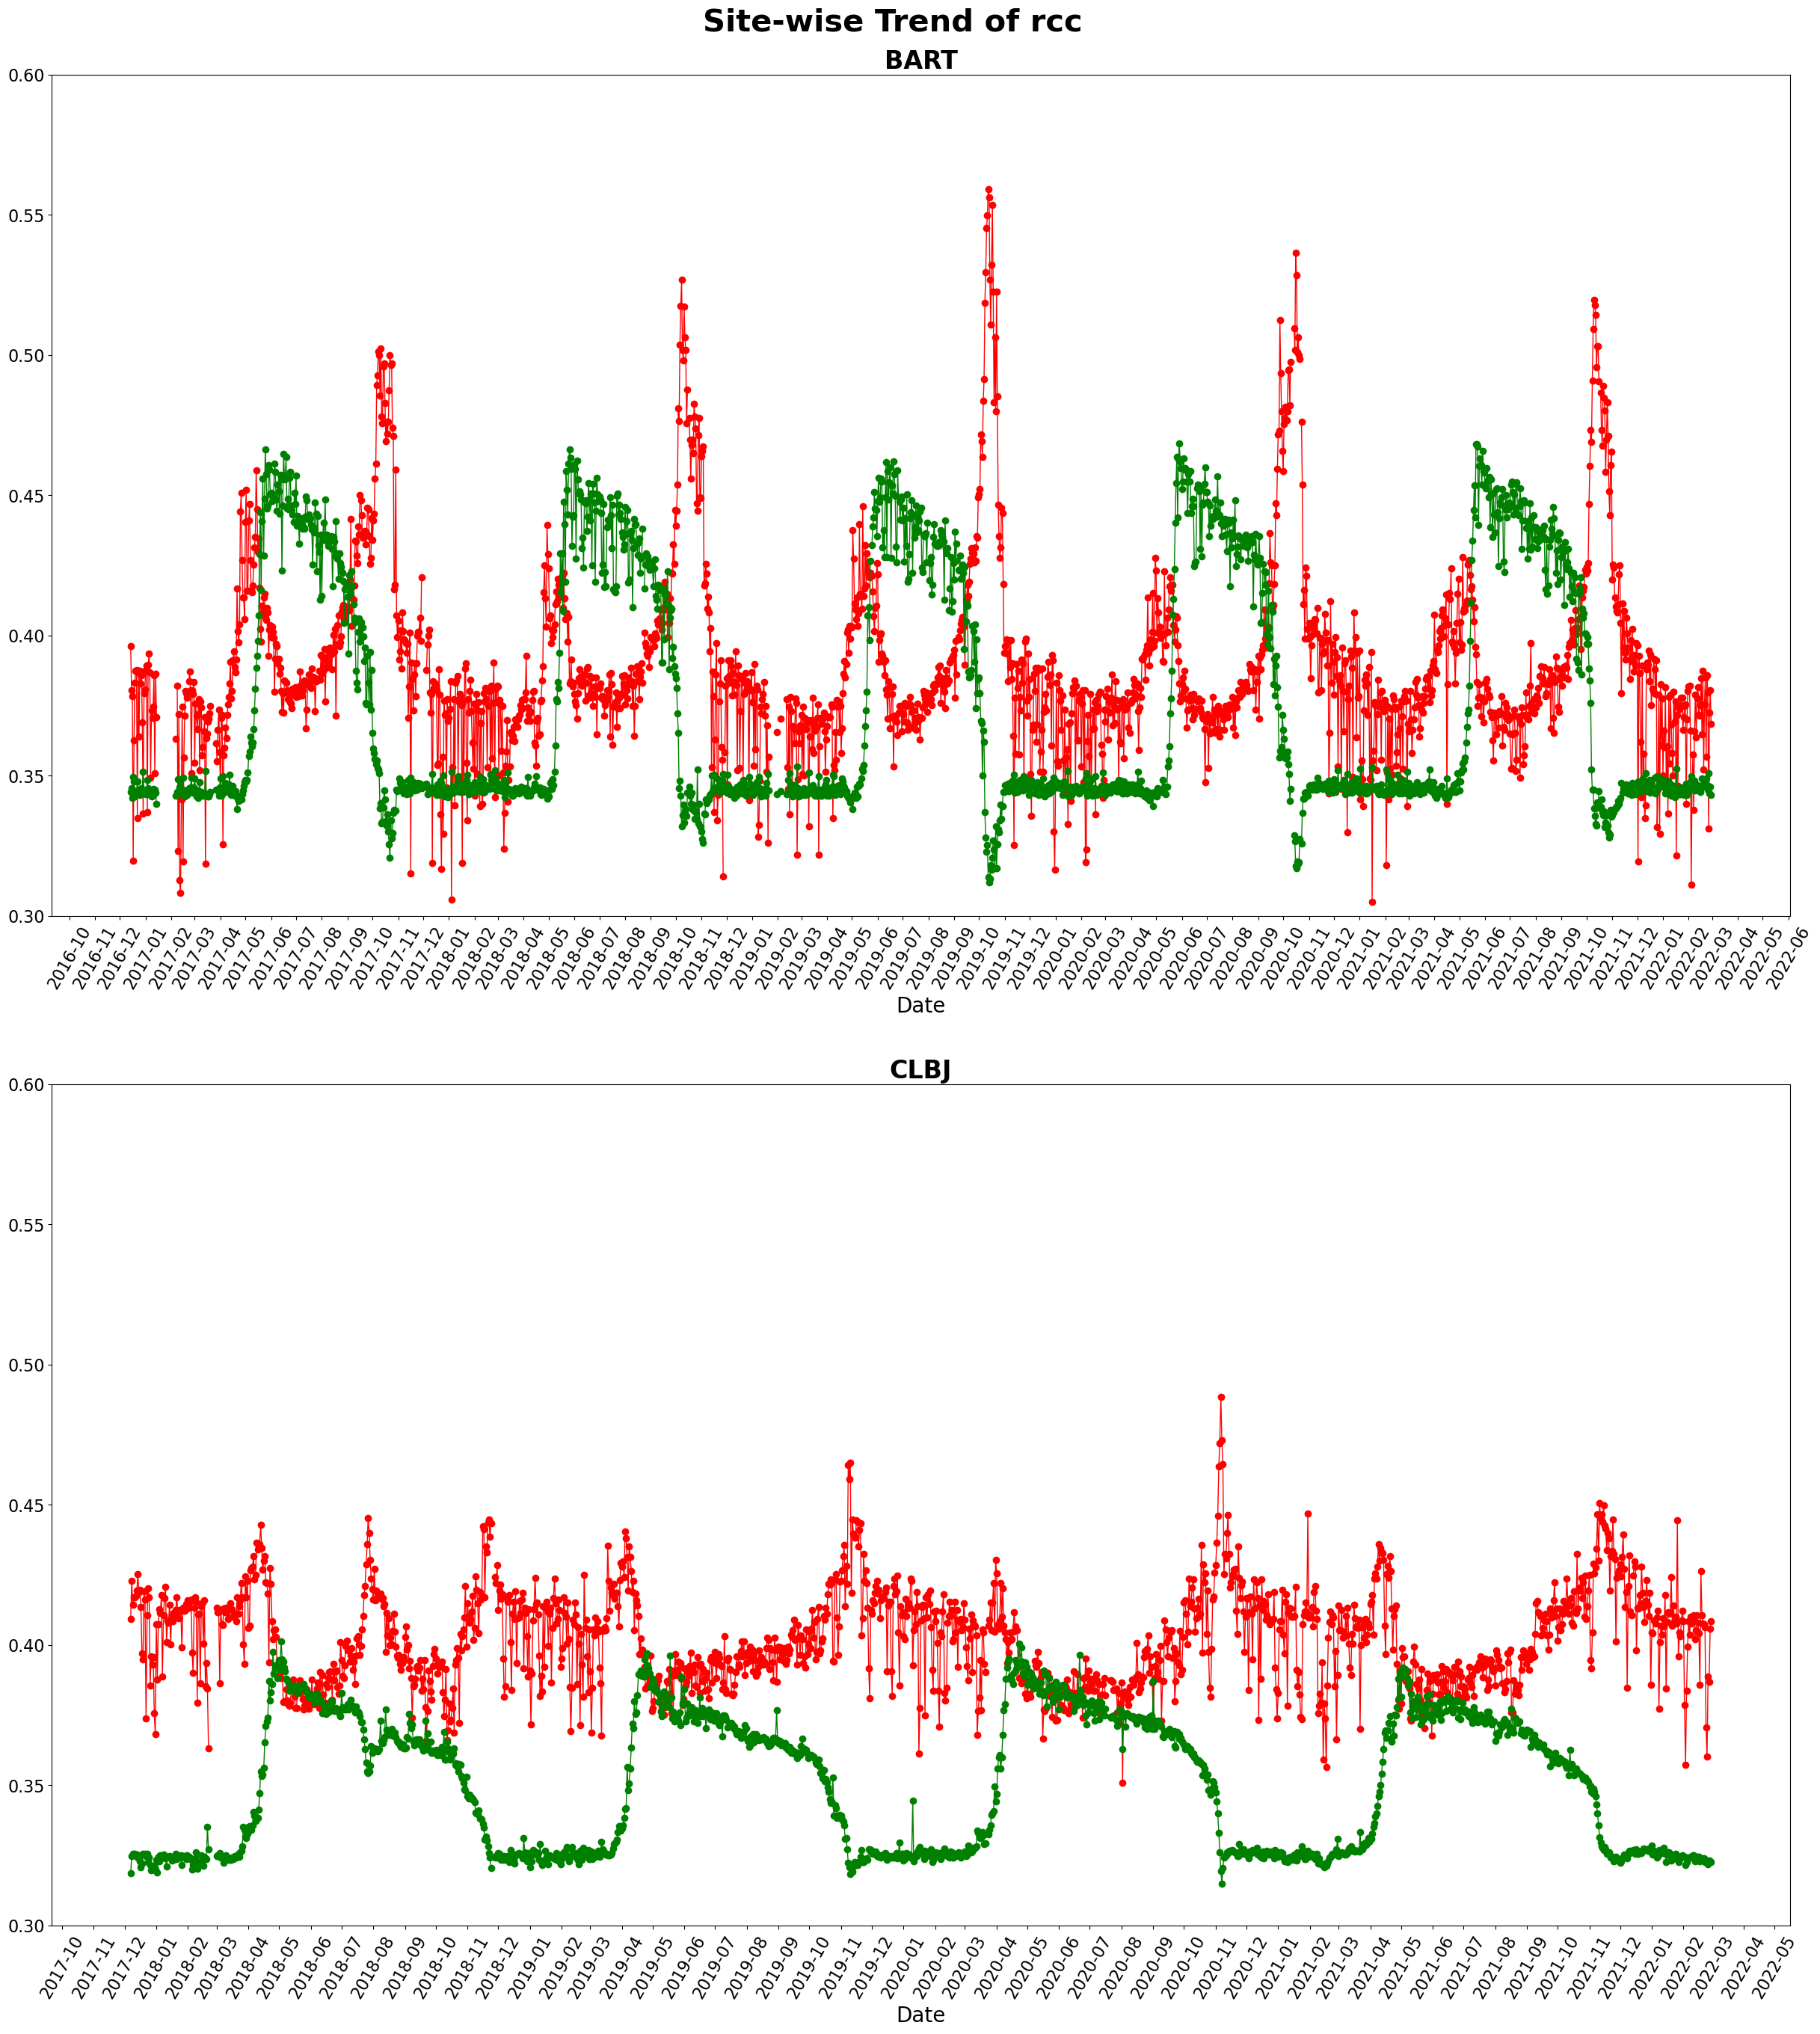

In [11]:
fig, ax = plt.subplots(2, 1, figsize = (30, 30), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of rcc", fontsize=30, fontweight='bold')

for k in range(0,2):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(rcc_site_data[k]["time"], rcc_site_data[k]["rcc_90"], color = 'red', lw=1, marker = 'o', label = "rcc")
    ax[k].plot(gcc_site_data[k]["time"], gcc_site_data[k]["gcc_90"], color = 'green', lw=1, marker = 'o', label = "gcc")
    ax[k].set_ylim(0.3,0.6)
    #ax[k].set_ylabel("rcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)  
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
plt.subplots_adjust(top=0.95)

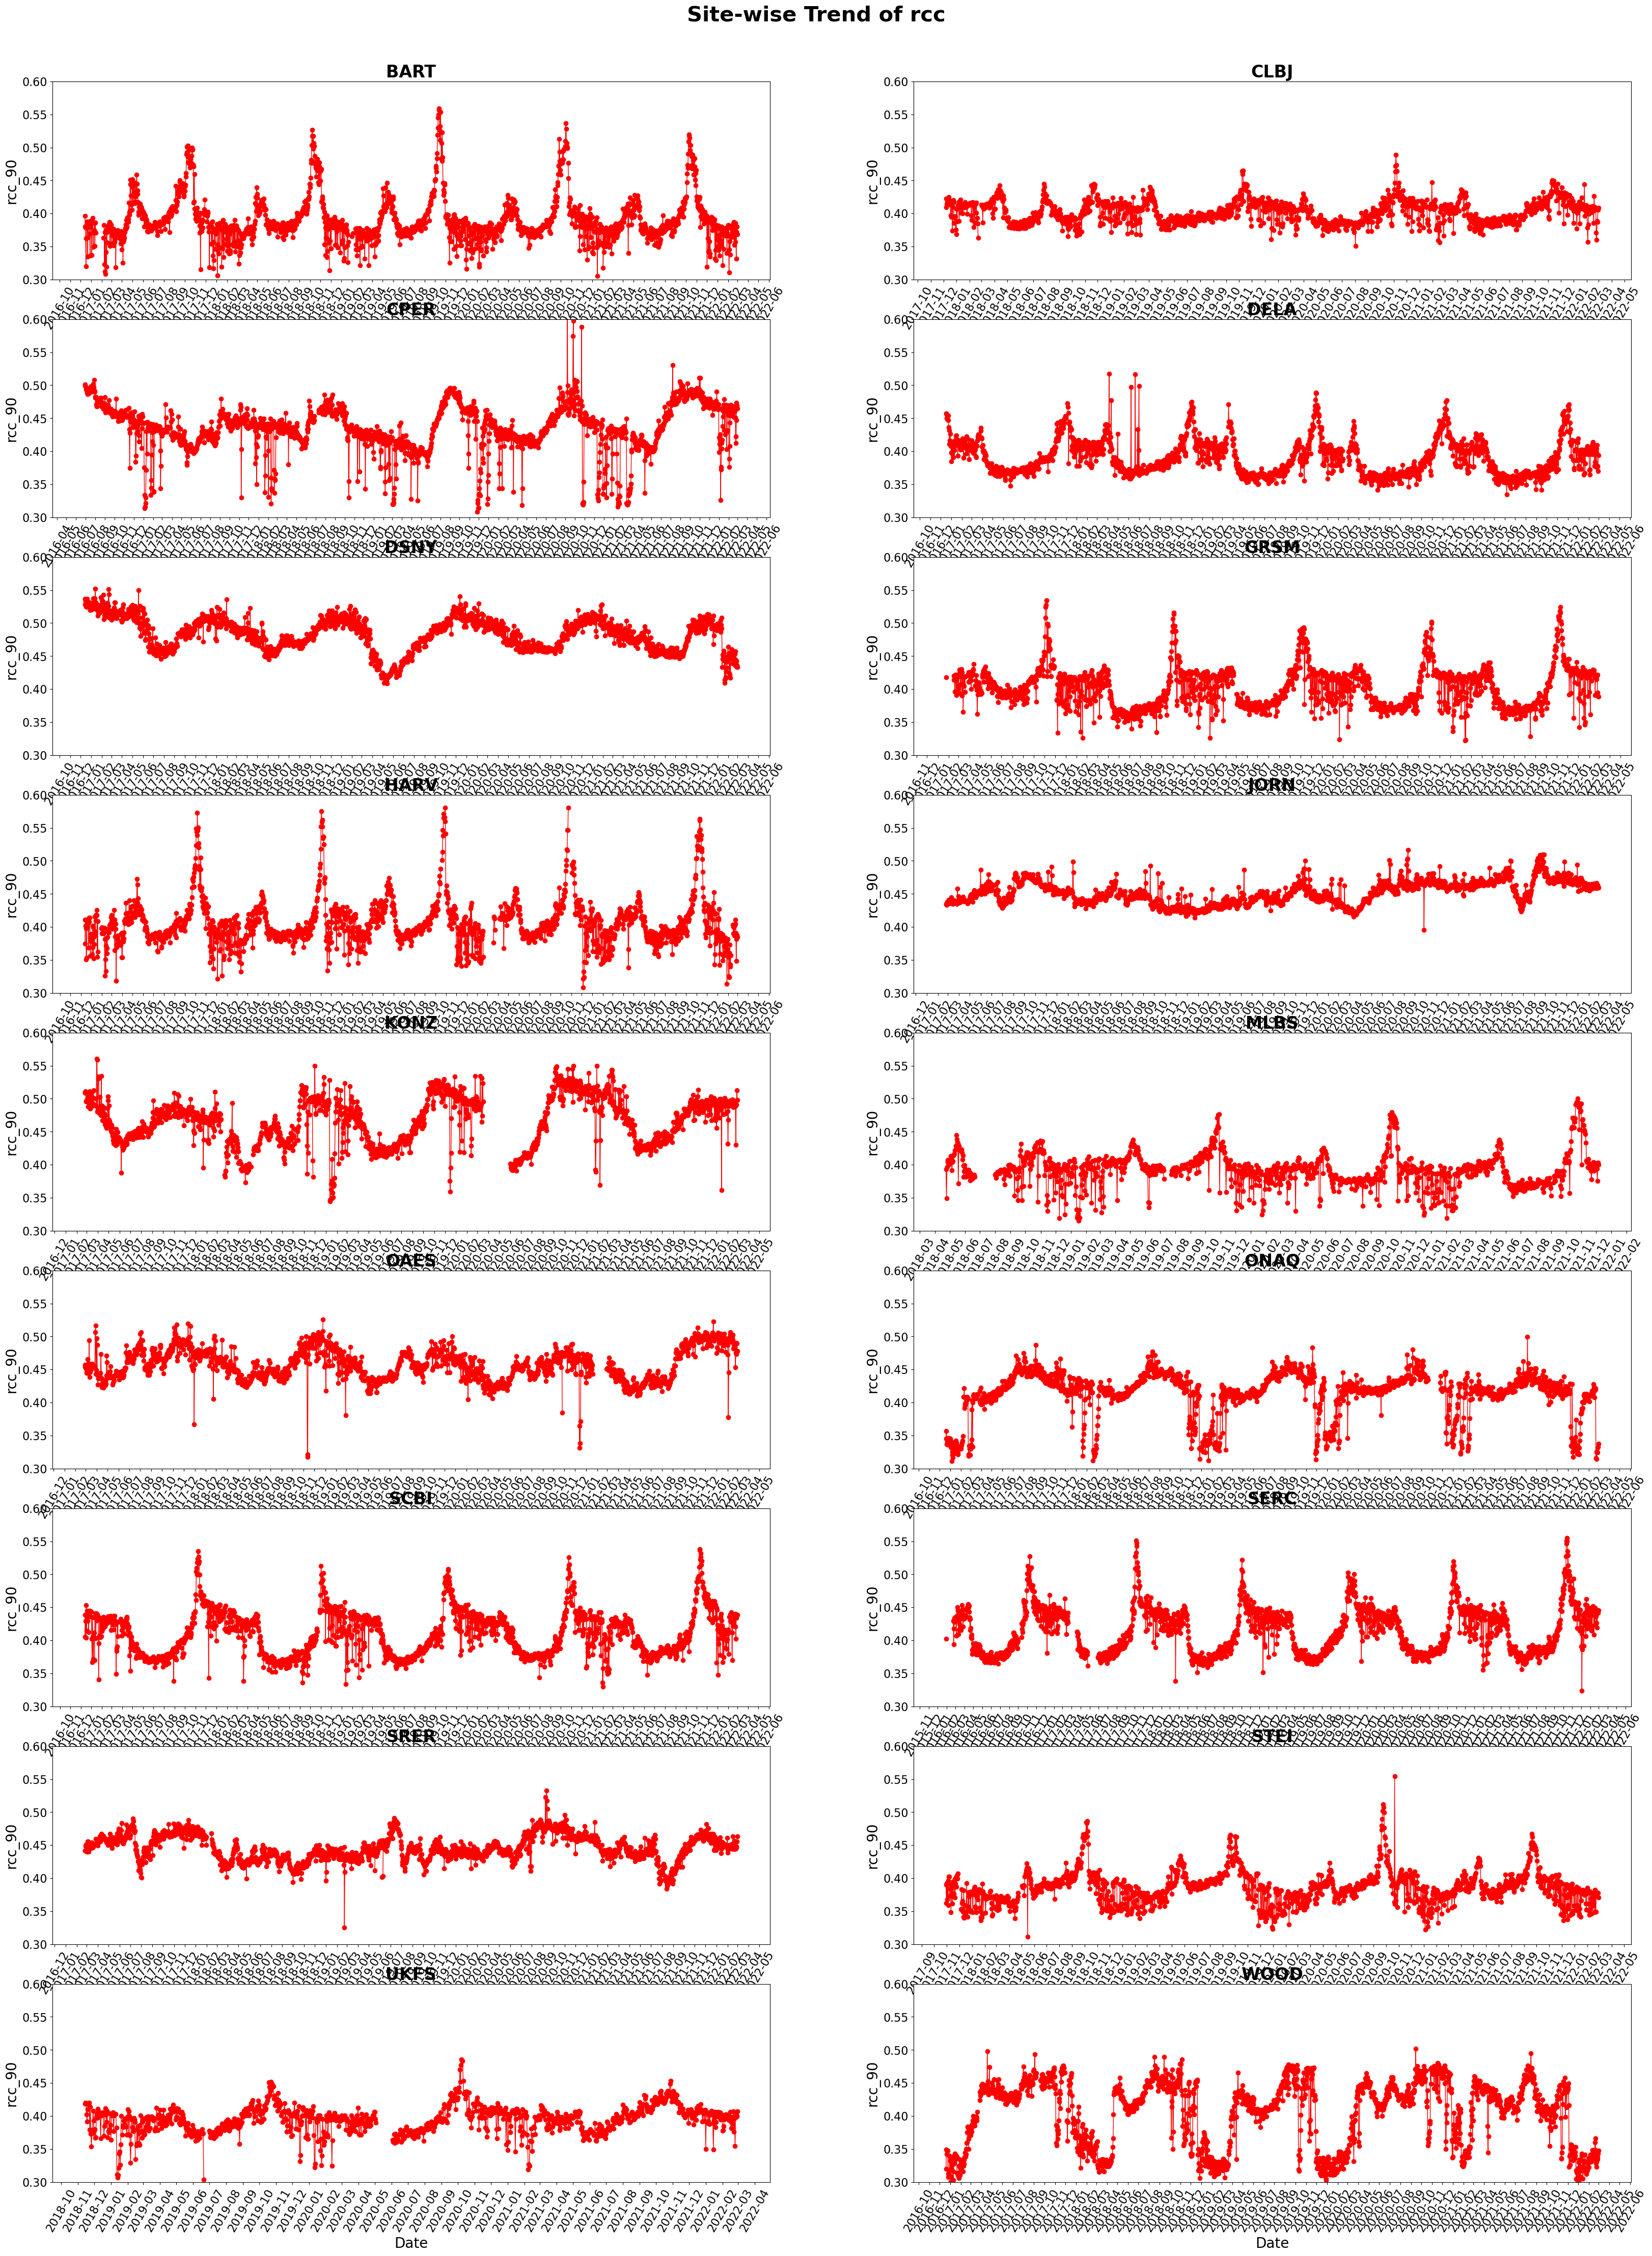

In [12]:
fig, ax = plt.subplots(9, 2, figsize = (40, 50), dpi = 100)
ax = ax.flatten()
fig.suptitle("Site-wise Trend of rcc", fontsize=30, fontweight='bold')

for k in range(0,num_sites):
    ax[k].set_title(site_list[k], fontsize=24, fontweight='bold')
    ax[k].plot(rcc_site_data[k]["time"], rcc_site_data[k]["rcc_90"], color = 'red', lw=1, marker = 'o')
    ax[k].set_ylim(0.3,0.6)
    ax[k].set_ylabel("rcc_90", fontsize=20)
    ax[k].set_xlabel("Date", fontsize=20) 
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)
    for tick in ax[k].get_xticklabels():
        tick.set_rotation(60)
    
plt.subplots_adjust(top=0.95)

### RCC prediction

In [13]:
#Creating features by using shift() function with rcc dataset

input_features = ['radiation', 'max_temp', 'min_temp', 'precip']
target_variables = ['rcc_90']
for k in range(0,num_sites):
    for i in range(1,11):     #Creating features columns for last 10 days from last year
        col_name_last_year = "last_year_rcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        rcc_site_data[k].loc[:,col_name_last_year] = rcc_site_data[k].loc[:,"rcc_90"].shift(i+365)
    for i in range(0,10):     #Creating features columns for t to (t+9) days from last year
        col_name_last_year_ahead = "last_year_rcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        rcc_site_data[k].loc[:,col_name_last_year_ahead] = rcc_site_data[k].loc[:,"rcc_90"].shift(365-i)

C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [14]:
print("Input Features for rcc prediction:\n" + str(input_features))
print("\nTarget Variables for rcc prediction:\n" + str(target_variables))

Input Features for rcc prediction:
['radiation', 'max_temp', 'min_temp', 'precip', 'last_year_rcc_90_(t-1)', 'last_year_rcc_90_(t-2)', 'last_year_rcc_90_(t-3)', 'last_year_rcc_90_(t-4)', 'last_year_rcc_90_(t-5)', 'last_year_rcc_90_(t-6)', 'last_year_rcc_90_(t-7)', 'last_year_rcc_90_(t-8)', 'last_year_rcc_90_(t-9)', 'last_year_rcc_90_(t-10)', 'last_year_rcc_90_(t+0)', 'last_year_rcc_90_(t+1)', 'last_year_rcc_90_(t+2)', 'last_year_rcc_90_(t+3)', 'last_year_rcc_90_(t+4)', 'last_year_rcc_90_(t+5)', 'last_year_rcc_90_(t+6)', 'last_year_rcc_90_(t+7)', 'last_year_rcc_90_(t+8)', 'last_year_rcc_90_(t+9)']

Target Variables for rcc prediction:
['rcc_90']


In [15]:
#drop missing values
for k in range(0,num_sites):
    rcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)

<ipython-input-15-2cf7a8215b7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)
<ipython-input-15-2cf7a8215b7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rcc_site_data[k].dropna(subset = input_features + target_variables, inplace = True)
<ipython-input-15-2cf7a8215b7a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rcc_site_data[k].dropna(subs

In [16]:
# data count for each year after dropping missing values
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,num_sites):
    data_count[site_list[k]] =  rcc_site_data[k].groupby("year").count().iloc[:, 1]
data_count

BART   CLBJ   CPER   DELA   DSNY   GRSM   HARV   JORN   KONZ   MLBS  \
2016    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2017    8.0    NaN  161.0    6.0    8.0    NaN    7.0    NaN    NaN    NaN   
2018  257.0   15.0  256.0  296.0  272.0  221.0  291.0  188.0  236.0    NaN   
2019  284.0  317.0  331.0  361.0  365.0  350.0  341.0  365.0  244.0  180.0   
2020  251.0  357.0  344.0  320.0  354.0  281.0  259.0  357.0  289.0  310.0   
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

       OAES   ONAQ   SCBI   SERC   SRER   STEI   UKFS   WOOD  
2016    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN  
2017    NaN    3.0    9.0  165.0    NaN    NaN    NaN    3.0  
2018  227.0  291.0  281.0  218.0  246.0   28.0    NaN  243.0  
2019  317.0  339.0  223.0  324.0  312.0  335.0   38.0  365.0  
2020  288.0  310.0  321.0  327.0  281.0  325.0  231.0  365.0  
2021    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN

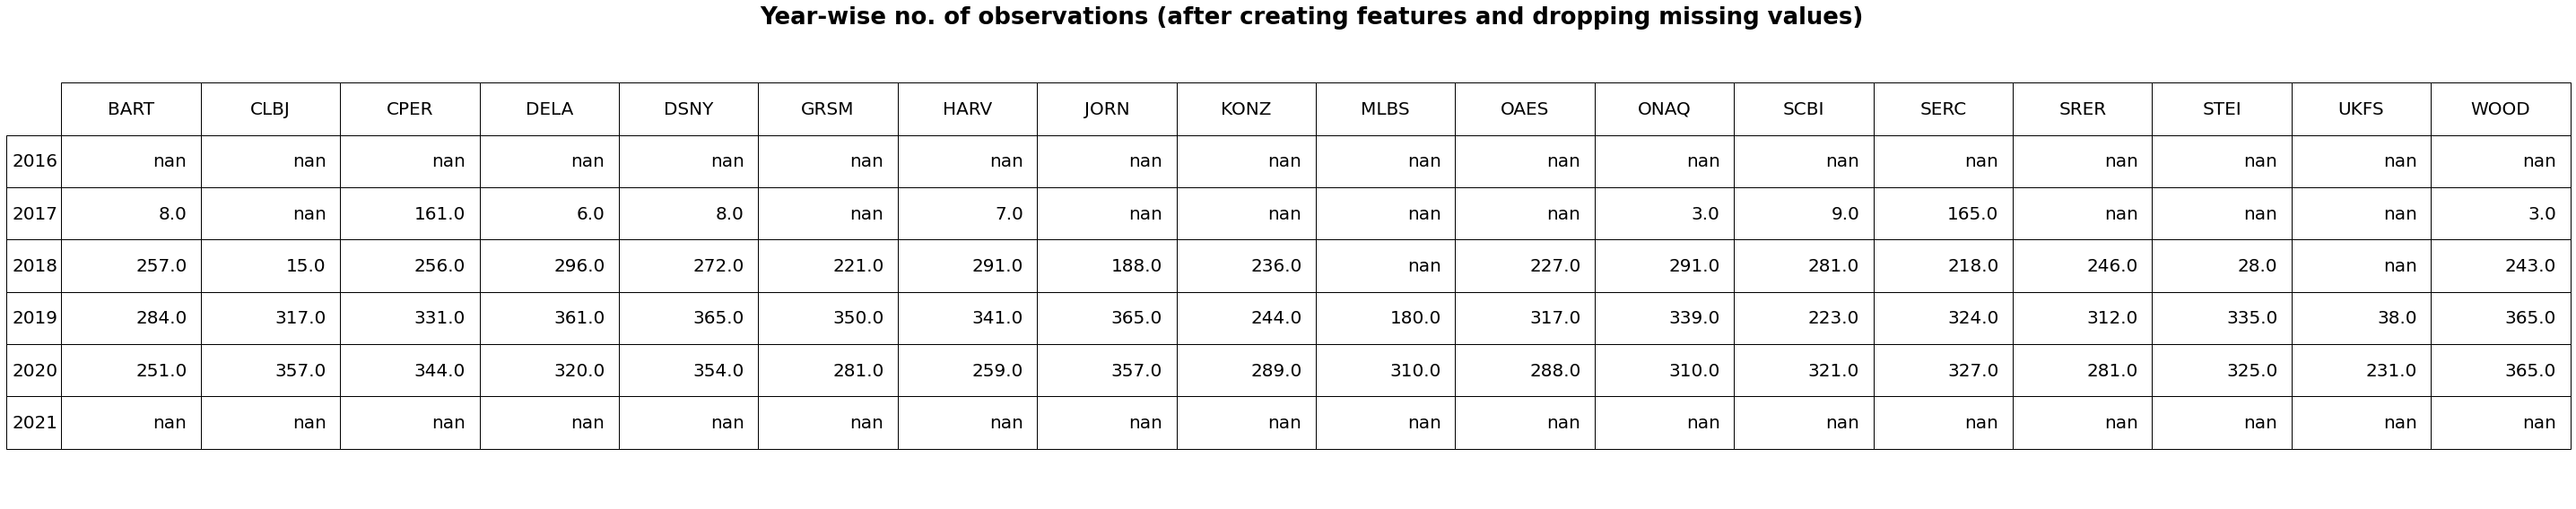

In [17]:
fig = plt.figure(figsize=(40,8))
table = plt.table(np.array(data_count), rowLabels = [2016, 2017, 2018, 2019, 2020, 2021],
                      colLabels = site_list,
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values) ", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()

In [18]:
for k in range(0,num_sites):
    rcc_site_data[k] = rcc_site_data[k].set_index("time")


HARV:

Shape of X_train:(639, 24)
Shape of Y_train:(639,)
Shape of X_test:(259, 24)
Shape of Y_test:(259,)

Best Model:RandomForestRegressor(max_depth=11, max_features=0.1, n_estimators=20)

Best Score:-0.03166766398731962

After 3-fold cross-validation with best parameters RFR: -0.033146 (+/- 0.006928)

Best Model:SVR(C=20, gamma=0.0001)

Best Score:-0.049444356030662266

After 3-fold cross-validation with best parameters SVR: -0.049444 (+/- 0.005190)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', valid

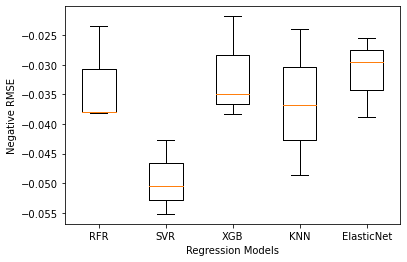


BART:

Shape of X_train:(549, 24)
Shape of Y_train:(549,)
Shape of X_test:(251, 24)
Shape of Y_test:(251,)

Best Model:RandomForestRegressor(max_depth=6, max_features=0.3, n_estimators=10)

Best Score:-0.0240316852701848

After 3-fold cross-validation with best parameters RFR: -0.025427 (+/- 0.008680)

Best Model:SVR(C=1, gamma=0.01)

Best Score:-0.04662422884522175

After 3-fold cross-validation with best parameters SVR: -0.046624 (+/- 0.007689)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_p

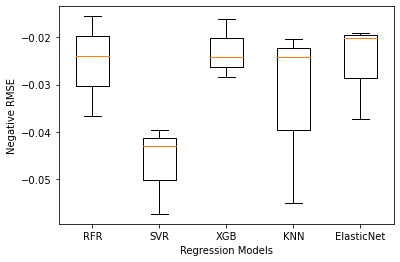


SCBI:

Shape of X_train:(513, 24)
Shape of Y_train:(513,)
Shape of X_test:(321, 24)
Shape of Y_test:(321,)

Best Model:RandomForestRegressor(max_depth=7, n_estimators=50)

Best Score:-0.020179638188220474

After 3-fold cross-validation with best parameters RFR: -0.020757 (+/- 0.000559)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.03756392908939571

After 3-fold cross-validation with best parameters SVR: -0.037564 (+/- 0.001602)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_p

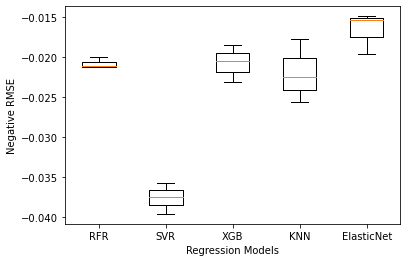


STEI:

Shape of X_train:(363, 24)
Shape of Y_train:(363,)
Shape of X_test:(325, 24)
Shape of Y_test:(325,)

Best Model:RandomForestRegressor(max_depth=11, max_features=0.4, n_estimators=10)

Best Score:-0.015868061297819824

After 3-fold cross-validation with best parameters RFR: -0.018682 (+/- 0.003127)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.029817542236703316

After 3-fold cross-validation with best parameters SVR: -0.029818 (+/- 0.003725)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method

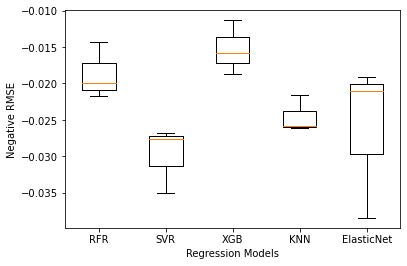


GRSM:

Shape of X_train:(571, 24)
Shape of Y_train:(571,)
Shape of X_test:(281, 24)
Shape of Y_test:(281,)

Best Model:RandomForestRegressor(max_depth=10, n_estimators=10)

Best Score:-0.026641827992446642

After 3-fold cross-validation with best parameters RFR: -0.028482 (+/- 0.009572)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.03986287414247252

After 3-fold cross-validation with best parameters SVR: -0.039863 (+/- 0.005493)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_p

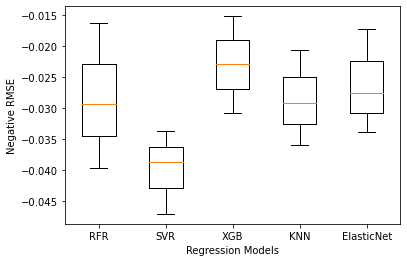


DELA:

Shape of X_train:(663, 24)
Shape of Y_train:(663,)
Shape of X_test:(320, 24)
Shape of Y_test:(320,)

Best Model:RandomForestRegressor(max_depth=8, max_features='log2', n_estimators=10)

Best Score:-0.01645716781384483

After 3-fold cross-validation with best parameters RFR: -0.018304 (+/- 0.003084)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.051920548859991054

After 3-fold cross-validation with best parameters SVR: -0.051921 (+/- 0.006956)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=60, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_meth

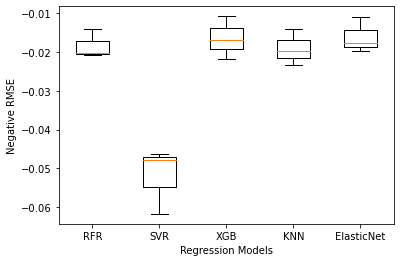


CLBJ:

Shape of X_train:(332, 24)
Shape of Y_train:(332,)
Shape of X_test:(357, 24)
Shape of Y_test:(357,)

Best Model:RandomForestRegressor(max_depth=9, max_features=0.1, n_estimators=20)

Best Score:-0.014736752696623284

After 3-fold cross-validation with best parameters RFR: -0.016260 (+/- 0.003054)

Best Model:SVR(C=1, gamma=0.1, kernel='linear')

Best Score:-0.015807541946547835

After 3-fold cross-validation with best parameters SVR: -0.015808 (+/- 0.003573)

Best Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.8, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=

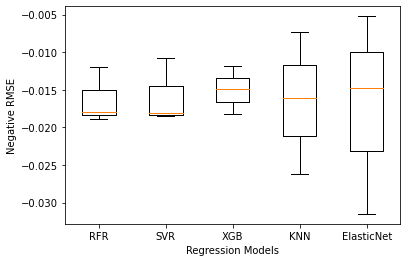

In [17]:
#Evaluating different machine learning algorithms

models = []
#models.append(('SGD', SGDRegressor()))

models.append(('RFR', RandomForestRegressor(), {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]}
              ))

models.append(('SVR', SVR(), {
    'C': [1, 5, 10, 15, 20], 
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001, 0.0001]}
              ))

models.append(('XGB', xgb.XGBRegressor(), {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0,1,11)],
    'max_depth' : [i for i in range(1, 20, 2)]}
              ))

models.append(('KNN', KNeighborsRegressor(), {
    'n_neighbors': [5, 8, 10, 15]}
              ))

models.append(('ElasticNet', ElasticNet(), {
    'alpha' : [0.01,0.001, 0.0001]}
              ))

for k in range(0,8):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc['2020', :]
    Y_test = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc['2020', :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of Y_train:" + str(Y_train.shape))
    print("Shape of X_test:" + str(X_test.shape))
    print("Shape of Y_test:" + str(Y_test.shape))
    
    results = []
    names = []
    for name, model, param_search in models:
        tscv = TimeSeriesSplit(n_splits = 3)
        gsearch = GridSearchCV(model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
        gsearch.fit(X_train, Y_train)
        best_score = gsearch.best_score_
        best_model = gsearch.best_estimator_
        print("\nBest Model:" + str(best_model))
        print("\nBest Score:" + str(best_score))
        
        
        cv_results = cross_val_score(best_model, X_train, Y_train, cv = tscv, scoring='neg_root_mean_squared_error')
        results.append(cv_results)
        names.append(name)
        print('\nAfter 3-fold cross-validation with best parameters %s: %f (+/- %f)' % (name, cv_results.mean(), cv_results.std()))
    
    plt.xlabel("Regression Models")
    plt.ylabel("Negative RMSE")
    plt.boxplot(results, labels = names)
    plt.show()

In [19]:
#Train the model using RFR
best_models_RFR = []
overall_rmse_score_RFR = []
overall_r2_score_RFR = []
true_results = []
predicted_results_RFR = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,30,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_RFR.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_RFR.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_RFR.append(rmse)
    overall_r2_score_RFR.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of X_train:(549,)
Shape of X_train:(251, 24)
Shape of X_train:(251,)
RMSE of Training Data: -0.024525737795151936
Model:RandomForestRegressor(max_depth=9, max_features=0.1, random_state=0)
explained_variance: 0.8069666789302943
RMSE: 0.01825526758041961
R2: 0.7671222813450285
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of X_train:(332,)
Shape of X_train:(357, 24)
Shape of X_train:(357,)
RMSE of Training Data: -0.013423837754018184
Model:RandomForestRegressor(max_depth=8, max_features=0.3, n_estimators=10,
                      random_state=0)
explained_variance: 0.5418781943804374
RMSE: 0.012926018080191575
R2: 0.5028426831266644
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of X_train:(748,)
Shape of X_train:(344, 24)
Shape of X_train:(344,)
RMSE of Training Data: -0.03064241610339269
Model:RandomForestRegres

In [20]:
#Train the models using XGB
best_models_XGB = []
overall_rmse_score_XGB = []
overall_r2_score_XGB = []
true_results = []
predicted_results_XGB = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = xgb.XGBRegressor(random_state = 100)
    param_search = {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0.1,1,10)],
    'max_depth' : [i for i in range(1, 20)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_XGB.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_XGB.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_XGB.append(rmse)
    overall_r2_score_XGB.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of X_train:(549,)
Shape of X_train:(251, 24)
Shape of X_train:(251,)
RMSE of Training Data: -0.022911084251522454
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
explained_variance: 0.7704260902096564
RMSE: 0.01894105189135474
R2: 0.7492968911118454
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of X_train:(332,)
Shape of X_train:(357, 24)
Shape of X_train:(357,)
R

RMSE of Training Data: -0.020330998270020495
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
explained_variance: -0.0925836981293251
RMSE: 0.019660301998650122
R2: -0.41406678071270453
------------------------------------------------------------------------

ONAQ:

Shape of X_train:(633, 24)
Shape of X_train:(633,)
Shape of X_train:(310, 24)
Shape of X_train:(310,)
RMSE of Training Data: -0.021113368684635463
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_

In [21]:
#Train the models using ElasticNet
best_models_ElasticNet = []
overall_rmse_score_ElasticNet = []
overall_r2_score_ElasticNet = []
true_results = []
predicted_results_ElasticNet = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = ElasticNet(random_state = 100)
    param_search = {
    'alpha': [0.001, 0.0001, 0.00001, 0.000001],
    'l1_ratio': [0.2, 0.3, 0.4, 0.5, 0.6]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_ElasticNet.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_ElasticNet.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_ElasticNet.append(rmse)
    overall_r2_score_ElasticNet.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of X_train:(549,)
Shape of X_train:(251, 24)
Shape of X_train:(251,)
RMSE of Training Data: -0.023782212512768682
Model:ElasticNet(alpha=1e-05, l1_ratio=0.6, random_state=100)
explained_variance: 0.8254111716999777
RMSE: 0.017703313539080404
R2: 0.7809916597056776
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of X_train:(332,)
Shape of X_train:(357, 24)
Shape of X_train:(357,)
RMSE of Training Data: -0.0171787113901968
Model:ElasticNet(alpha=0.001, l1_ratio=0.4, random_state=100)
explained_variance: 0.3914462420790441
RMSE: 0.01489318795483428
R2: 0.3400065002380366
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of X_train:(748,)
Shape of X_train:(344, 24)
Shape of X_train:(344,)
RMSE of Training Data: -0.027629046942056142
Model:ElasticNet(alpha=1e-05, l1_ratio=0.6, random_state=100)
explained_variance: 0.371179

C:\Users\palde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03398079012349098, tolerance: 2.4655931521677428e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\palde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.032749517169903083, tolerance: 2.4655931521677428e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\palde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.030707101585954678, tolerance: 2.4655931521677428e-05
  model = cd_fast.enet_coordinate_descent(
C:\Users\palde\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py

In [22]:
#Train the models using KNN Regressor
best_models_KNN = []
overall_rmse_score_KNN = []
overall_r2_score_KNN = []
true_results = []
predicted_results_KNN = []

for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    print("\n" + str(site_list[k]) + ":\n")
    X_train = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc[:'2019', :])
    X_test = rcc_site_data[k][rcc_site_data[k].columns.intersection(input_features)].loc['2020':, :]
    Y_test = np.ravel(rcc_site_data[k][rcc_site_data[k].columns.intersection(target_variables)].loc['2020':, :])
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = KNeighborsRegressor()
    param_search = {
    'n_neighbors': [5, 8, 10, 12, 15],
    'weights': ['uniform', 'distance']
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models_KNN.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results_KNN.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score_KNN.append(rmse)
    overall_r2_score_KNN.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

Shape of X_train:(549, 24)
Shape of X_train:(549,)
Shape of X_train:(251, 24)
Shape of X_train:(251,)
RMSE of Training Data: -0.03291969434801669
Model:KNeighborsRegressor(weights='distance')
explained_variance: 0.37359266230098476
RMSE: 0.02997268577192001
R2: 0.3722266820476908
------------------------------------------------------------------------

CLBJ:

Shape of X_train:(332, 24)
Shape of X_train:(332,)
Shape of X_train:(357, 24)
Shape of X_train:(357,)
RMSE of Training Data: -0.016562541654136256
Model:KNeighborsRegressor(n_neighbors=8)
explained_variance: 0.4754939288078601
RMSE: 0.013977857550517392
R2: 0.4186394770512275
------------------------------------------------------------------------

CPER:

Shape of X_train:(748, 24)
Shape of X_train:(748,)
Shape of X_train:(344, 24)
Shape of X_train:(344,)
RMSE of Training Data: -0.029899458367685445
Model:KNeighborsRegressor(n_neighbors=12, weights='distance')
explained_variance: 0.46975638138669984
RMSE: 0.025353082278691

In [25]:
site_list_modified = np.array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI','WOOD'])
site_list_modified

array(['BART', 'CLBJ', 'CPER', 'DELA', 'DSNY', 'GRSM', 'HARV', 'JORN',
       'KONZ', 'MLBS', 'OAES', 'ONAQ', 'SCBI', 'SERC', 'SRER', 'STEI',
       'WOOD'], dtype='<U4')

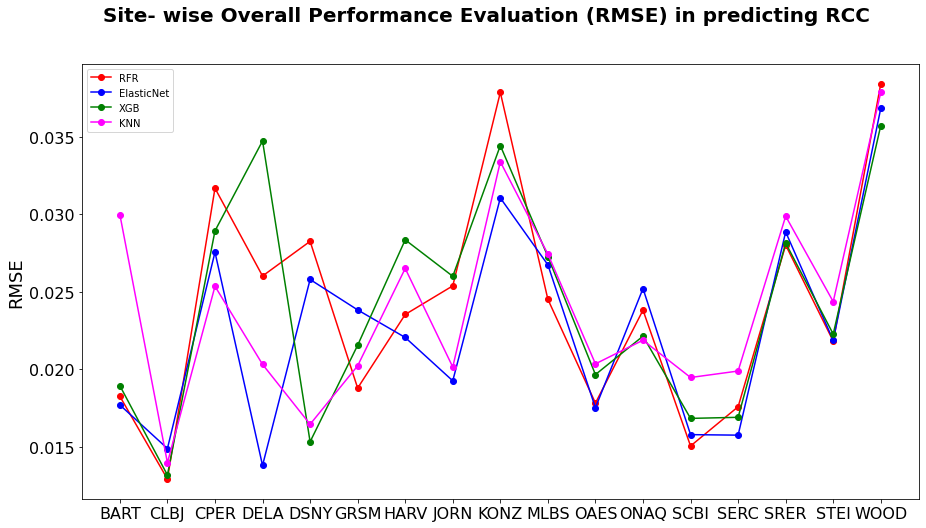

In [26]:
plt.figure(figsize = (15,8))
plt.suptitle("Site- wise Overall Performance Evaluation (RMSE) in predicting RCC", fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel("RMSE", fontsize = 18)
plt.plot(site_list_modified, overall_rmse_score_RFR, color = 'r', marker='o', label = "RFR")
plt.plot(site_list_modified, overall_rmse_score_ElasticNet, color = 'b', marker='o', label = "ElasticNet")
plt.plot(site_list_modified, overall_rmse_score_XGB, color = 'g', marker='o', label = "XGB")
plt.plot(site_list_modified, overall_rmse_score_KNN, color = 'magenta', marker='o', label = "KNN")

plt.legend()

<ipython-input-27-7ecdadb8570e>:18: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  f = pd.datetime(2020,7,1)


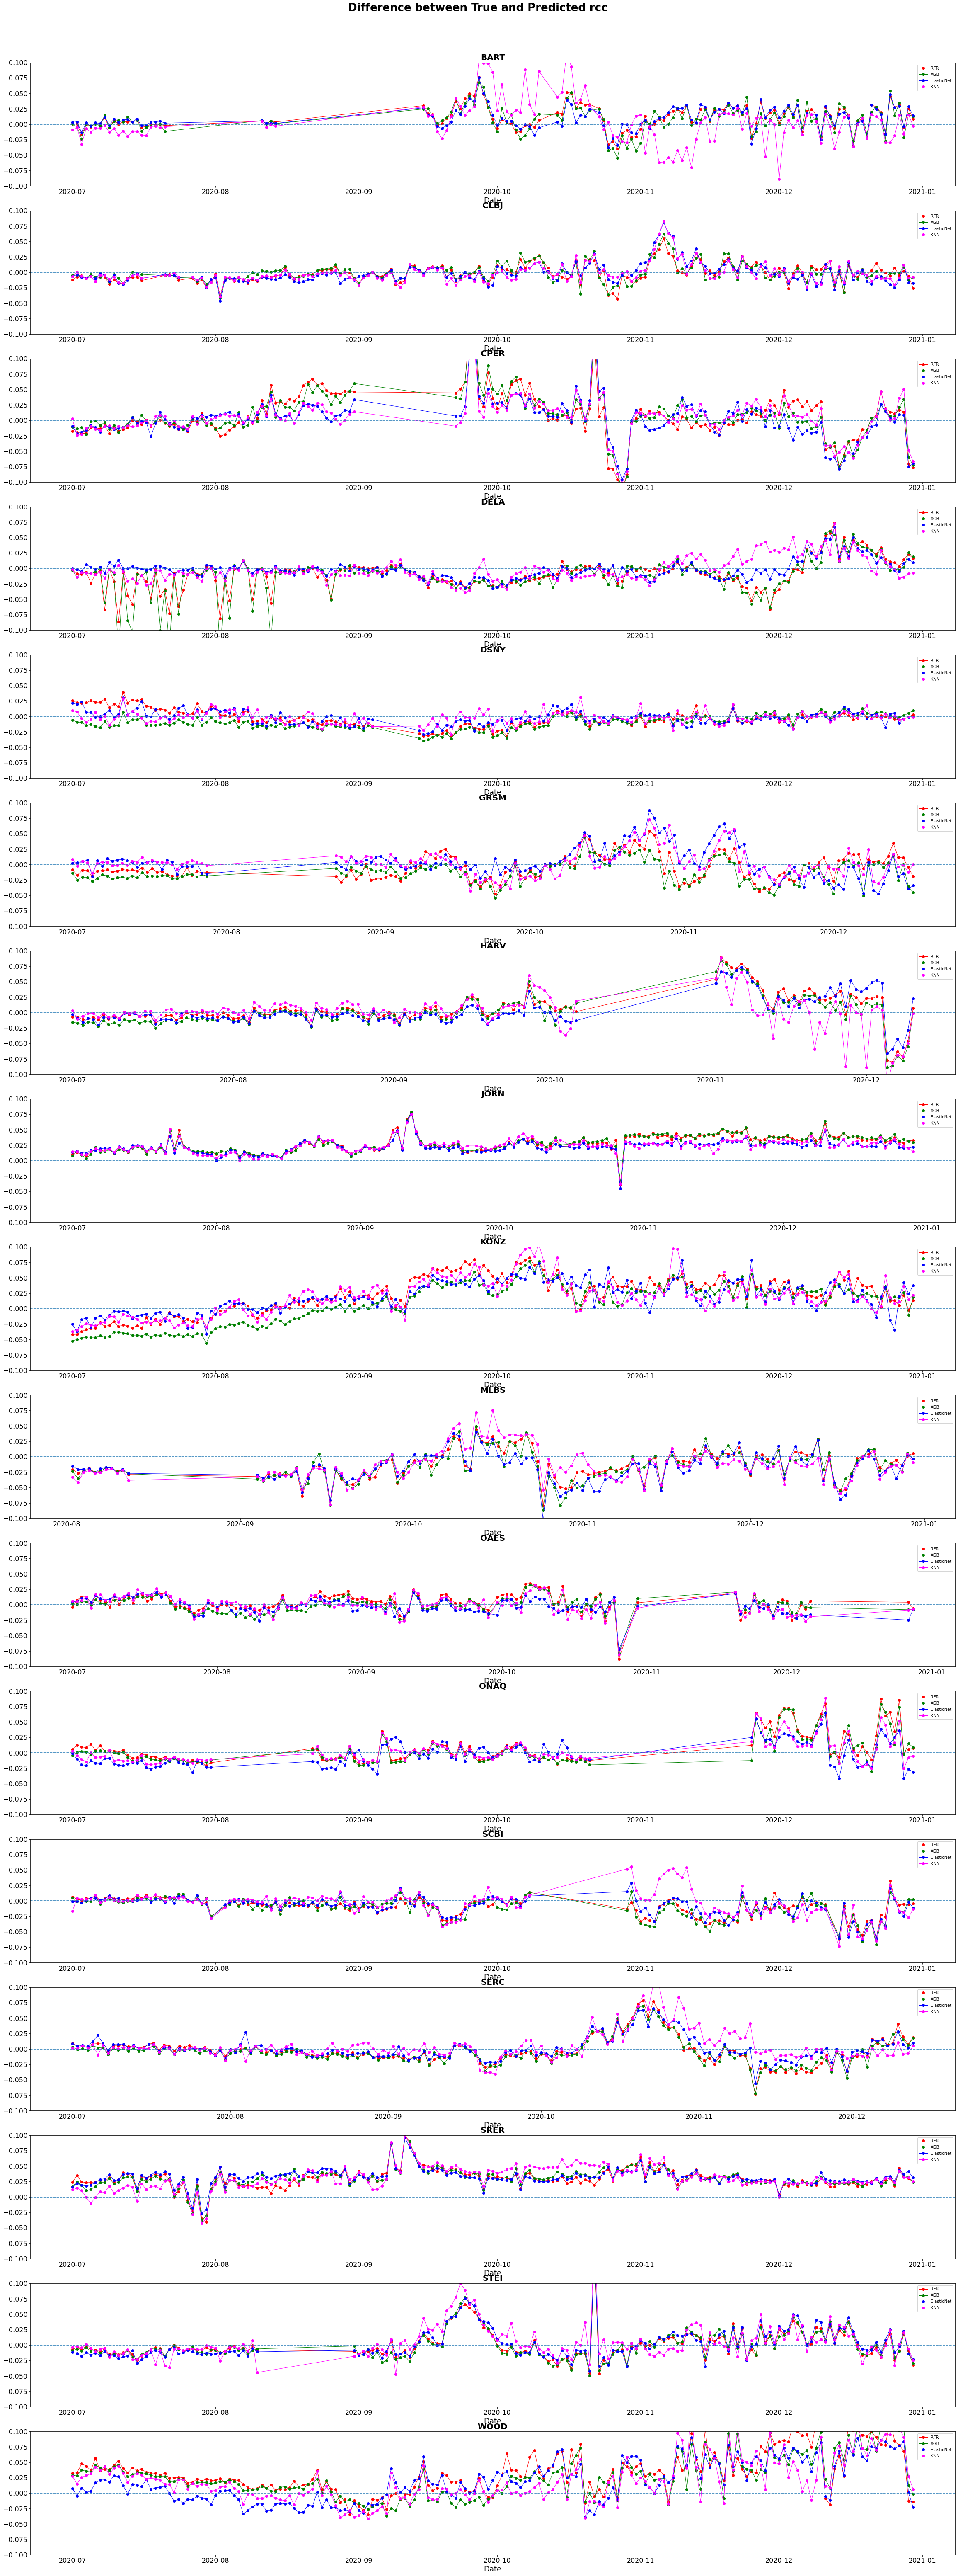

In [27]:
predicted_site_data = []
for k in range(0,num_sites):
    if (site_list[k] == "UKFS"):
        continue;
    predicted_site_data.append(rcc_site_data[k].loc['2020', :])

for k in range(0,num_sites-1):
    Y_pred_RFR = predicted_results_RFR[k]
    Y_pred_XGB = predicted_results_XGB[k]
    Y_pred_EN = predicted_results_ElasticNet[k]
    Y_pred_KNN = predicted_results_KNN[k]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_RFR", value = Y_pred_RFR)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_XGB", value = Y_pred_XGB)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_EN", value = Y_pred_EN)
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_KNN", value = Y_pred_KNN)

    
f = pd.datetime(2020,7,1)

fig, ax = plt.subplots(17, 1, figsize = (40, 100))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted rcc", fontsize=26, fontweight='bold')
for k in range(0,num_sites-1):
    df = predicted_site_data[k]
    df = df.reset_index()
    df = df.loc[df['time'] >= f]
    ax[k].set_title(site_list_modified[k], fontsize=20, fontweight='bold')
    ax[k].plot(df["time"], df["rcc_90"] - df["predicted_rcc_90_RFR"], color = 'red', lw=1, marker = 'o', label = 'RFR')
    ax[k].plot(df["time"], df["rcc_90"] - df["predicted_rcc_90_XGB"], color = 'green', lw=1, marker = 'o', label = 'XGB')
    ax[k].plot(df["time"], df["rcc_90"] - df["predicted_rcc_90_EN"], color = 'blue', lw=1, marker = 'o', label = 'ElasticNet')
    ax[k].plot(df["time"], df["rcc_90"] - df["predicted_rcc_90_KNN"], color = 'magenta', lw=1, marker = 'o', label = 'KNN')
    ax[k].set_xlabel("Date", fontsize = 18) 
    ax[k].set_ylim(-0.1,0.1)
    ax[k].axhline(y=0, linestyle = '--')
    ax[k].xaxis.set_major_locator(MonthLocator())
    ax[k].tick_params(axis='both', which='major', labelsize=16)
    ax[k].legend()
plt.subplots_adjust(top=0.96)

In [28]:
for k in range(0,num_sites-1):
    df = predicted_site_data[k][["predicted_rcc_90_RFR", "predicted_rcc_90_XGB", "predicted_rcc_90_EN", "predicted_rcc_90_KNN"]]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_mean", 
                                 value = df.mean(axis=1))
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_std", 
                                  value = df.std(axis=1))

In [33]:
for k in range(0,num_sites-1):
    df = predicted_site_data[k][["predicted_rcc_90_RFR", "predicted_rcc_90_XGB", "predicted_rcc_90_EN"]]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_mean_wo_KNN", 
                                 value = df.mean(axis=1))
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_rcc_90_std_wo_KNN", 
                                  value = df.std(axis=1))

In [34]:
rmse_modified = []
for k in range(0,num_sites-1):
    y_pred = np.array(predicted_site_data[k]["predicted_rcc_90_mean"])
    y_true = np.array(predicted_site_data[k]["rcc_90"])
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    
    rmse_modified.append(rmse)
    
    print("\n" + str(site_list_modified[k]) + ":\n")
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

explained_variance: 0.8070440077706964
RMSE: 0.01732615734665176
R2: 0.7902238841035157
------------------------------------------------------------------------

CLBJ:

explained_variance: 0.5712812225707977
RMSE: 0.012594075820686829
R2: 0.5280489848945531
------------------------------------------------------------------------

CPER:

explained_variance: 0.4155115890845402
RMSE: 0.026817277857815017
R2: 0.40328680679848716
------------------------------------------------------------------------

DELA:

explained_variance: 0.6008172763088473
RMSE: 0.020204094428797358
R2: 0.4590702961148395
------------------------------------------------------------------------

DSNY:

explained_variance: 0.03728068939075857
RMSE: 0.0197064195590865
R2: -0.18049913521959793
------------------------------------------------------------------------

GRSM:

explained_variance: 0.6752839980392766
RMSE: 0.017605532776252212
R2: 0.6588262873912278
----------------------------------------------------

In [35]:
rmse_modified_wo_KNN = []
for k in range(0,num_sites-1):
    y_pred = np.array(predicted_site_data[k]["predicted_rcc_90_mean_wo_KNN"])
    y_true = np.array(predicted_site_data[k]["rcc_90"])
    
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(y_true, y_pred)
    
    rmse_modified_wo_KNN.append(rmse)
    
    print("\n" + str(site_list_modified[k]) + ":\n")
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


BART:

explained_variance: 0.8165524989676359
RMSE: 0.017652886643558366
R2: 0.7822375486959041
------------------------------------------------------------------------

CLBJ:

explained_variance: 0.5659576950871872
RMSE: 0.012610033084601461
R2: 0.5268522606412291
------------------------------------------------------------------------

CPER:

explained_variance: 0.3693045034703363
RMSE: 0.027931092605293494
R2: 0.352690313555033
------------------------------------------------------------------------

DELA:

explained_variance: 0.4764242736421517
RMSE: 0.022768228288852527
R2: 0.31305727955599416
------------------------------------------------------------------------

DSNY:

explained_variance: -0.15575734211339332
RMSE: 0.0216168205751374
R2: -0.42047586506092616
------------------------------------------------------------------------

GRSM:

explained_variance: 0.6717204119827347
RMSE: 0.017979988349069203
R2: 0.6441589647425643
---------------------------------------------------

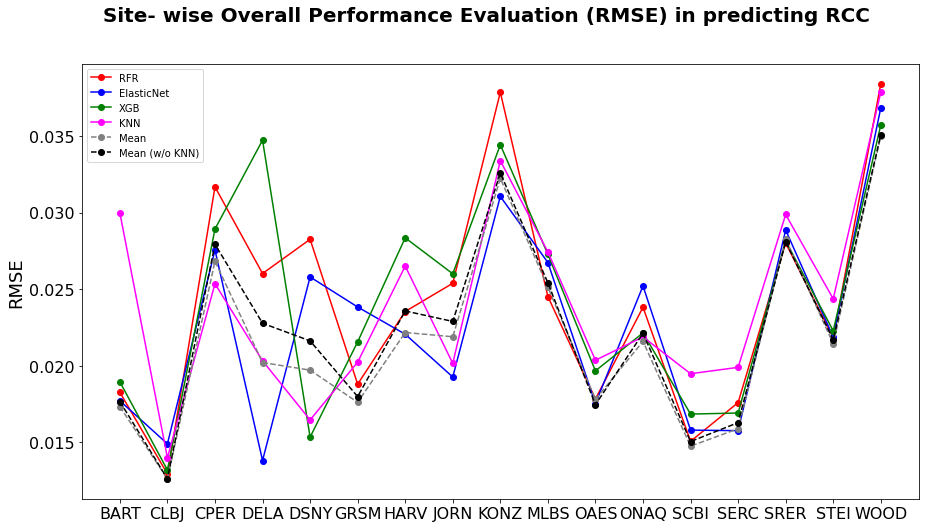

In [36]:
plt.figure(figsize = (15,8))
plt.suptitle("Site- wise Overall Performance Evaluation (RMSE) in predicting RCC", fontsize=20, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ylabel("RMSE", fontsize = 18)
plt.plot(site_list_modified, overall_rmse_score_RFR, color = 'r', marker='o', label = "RFR")
plt.plot(site_list_modified, overall_rmse_score_ElasticNet, color = 'b', marker='o', label = "ElasticNet")
plt.plot(site_list_modified, overall_rmse_score_XGB, color = 'g', marker='o', label = "XGB")
plt.plot(site_list_modified, overall_rmse_score_KNN, color = 'magenta', marker='o', label = "KNN")
plt.plot(site_list_modified, rmse_modified, color = 'gray', marker='o', linestyle = '--', label = "Mean")
plt.plot(site_list_modified, rmse_modified_wo_KNN, color = 'black', marker='o', linestyle = '--', label = "Mean (w/o KNN)")

plt.legend()

In [23]:
# Finding no. of observations by month and year
data_count_monthwise = pd.DataFrame(index = ['2018-1', '2018-2', '2018-3', '2018-4', '2018-5', '2018-6', '2018-7', 
                                             '2018-8', '2018-9', '2018-10', '2018-11', '2018-12', '2019-1', '2019-2', 
                                             '2019-3', '2019-4', '2019-5', '2019-6', '2019-7', '2019-8', '2019-9', 
                                             '2019-10', '2019-11', '2019-12', '2020-1', '2020-2', '2020-3', '2020-4', 
                                             '2020-5', '2020-6', '2020-7', '2020-8', '2020-9', '2020-10', '2020-11', 
                                             '2020-12'])
for k in range(0,8):
    data_count_monthwise[site_list[k]] =  rcc_site_data[k].groupby("year_month").count().iloc[:, 1]
data_count_monthwise

HARV  BART  SCBI  STEI  UKFS  GRSM  DELA  CLBJ
2018-1     11   5.0    27   NaN   NaN   NaN    28   NaN
2018-2     11   NaN    11   NaN   NaN   4.0    11   NaN
2018-3     11   8.0    10   NaN   NaN  11.0    11   NaN
2018-4     25  25.0    25   NaN   NaN   NaN    25   NaN
2018-5     31  31.0    28   NaN   NaN  16.0    31   NaN
2018-6     30  30.0    30   NaN   NaN  30.0    30   NaN
2018-7     31  31.0    31   NaN   NaN  31.0    31   NaN
2018-8     31  30.0    31   NaN   NaN  31.0    31   NaN
2018-9     30  30.0    26   NaN   NaN  30.0    30   NaN
2018-10    31  30.0    25   NaN   NaN  31.0    31   NaN
2018-11    30  20.0    20  11.0   NaN  20.0    20   NaN
2018-12    19  17.0    17  17.0   NaN  17.0    17  15.0
2019-1     22  22.0    13  31.0   NaN  31.0    31  31.0
2019-2     28  19.0     7  28.0   NaN  28.0    28  12.0
2019-3     31  31.0     6  31.0   NaN  30.0    27  21.0
2019-4     29  30.0    22  14.0   NaN  24.0    30  30.0
2019-5     31  30.0     9  18.0   NaN  30.0    31  31.0
2019-6     30  30.0    30  30.0   NaN  30.0    30  30.0
2019-7     31  31.0    31  31.0   NaN  31.0    31  31.0
2019-8     31  12.0    22  30.0   NaN  25.0    31  31.0
2019-9     30  27.0    16  30.0   NaN  30.0    30  30.0
2019-10    27  11.0    13  31.0   NaN  31.0    31  31.0
2019-11    30  18.0    23  30.0   7.0  30.0    30  15.0
2019-12    21  23.0    31  31.0  31.0  30.0    31  24.0
2020-1     20  12.0    31  31.0  11.0  31.0    31  31.0
2020-2     18   9.0    15  29.0   9.0  29.0    15  29.0
2020-3      5  31.0    25  31.0  18.0  11.0     7  29.0
2020-4     18  30.0    30  24.0  10.0  14.0    23  30.0
2020-5     31  13.0    31  17.0   NaN  21.0    31  31.0
2020-6     30  28.0    30  30.0   9.0  30.0    30  30.0
2020-7     31  21.0    31  31.0  22.0  28.0    31  25.0
2020-8     31   4.0    29  11.0  31.0   9.0    31  31.0
2020-9     30  16.0    30  30.0  30.0  30.0    30  30.0
2020-10     6  27.0    11  31.0  31.0  31.0    31  31.0
2020-11    29  30.0    30  30.0  30.0  30.0    30  30.0
2020-12    10  30.0    28  30.0  30.0  17.0    30  30.0

#### Final decision is to take average of the four models: RFR, ElasticNet, XGB and KNN. Now, UKFS is trained with these three models for the future predictions without validation

In [37]:
#Train RFR model for UKFS and update best_models_RFR list

UKFS_X_train = rcc_site_data[4][rcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(rcc_site_data[4][rcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))
 
model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,30,50,100],
    'max_features': ['auto', 'sqrt','log2', 0.1, 0.2, 0.3, 0.4],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_RFR.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.023834960643034735
Model:RandomForestRegressor(max_depth=11, max_features=0.3, n_estimators=10,
                      random_state=0)


In [38]:
#Train the UKFS models using XGB

UKFS_X_train = rcc_site_data[4][rcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(rcc_site_data[4][rcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))

model = xgb.XGBRegressor(random_state = 100)
param_search = {
    'n_estimators' : [5, 10, 20, 30, 60],
    'learning_rate': [i for i in np.linspace(0.1,1,10)],
    'max_depth' : [i for i in range(1, 20)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_XGB.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.02164526962112866
Model:XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=30, n_jobs=8, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [39]:
#Train the models using ElasticNet

UKFS_X_train = rcc_site_data[4][rcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(rcc_site_data[4][rcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))

model = ElasticNet(random_state = 100, max_iter = 4000)
param_search = {
    'alpha': [0.1, 0.05, 0.01, 0.001, 0.0001, 0.00001, 0.000001],
    'l1_ratio': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_ElasticNet.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.019927020389917185
Model:ElasticNet(alpha=0.05, l1_ratio=0.01, max_iter=4000, random_state=100)


In [40]:
#Train the UKFS model using KNN Regressor

UKFS_X_train = rcc_site_data[4][rcc_site_data[4].columns.intersection(input_features)]
UKFS_Y_train = np.ravel(rcc_site_data[4][rcc_site_data[4].columns.intersection(target_variables)])
print("Shape of X_train:" + str(UKFS_X_train.shape))
print("Shape of Y_train:" + str(UKFS_Y_train.shape))

model = KNeighborsRegressor()
param_search = {
    'n_neighbors': [5, 8, 10, 12, 15],
    'weights': ['uniform', 'distance']
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_Y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models_KNN.append(best_model)
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

Shape of X_train:(999, 24)
Shape of Y_train:(999,)
RMSE of Training Data: -0.02077777345002554
Model:KNeighborsRegressor(n_neighbors=15, weights='distance')


In [42]:
#Added the site "UKFS" at the end
site_list_modified = np.append(site_list_modified, "UKFS")
print(site_list_modified)

['BART' 'CLBJ' 'CPER' 'DELA' 'DSNY' 'GRSM' 'HARV' 'JORN' 'KONZ' 'MLBS'
 'OAES' 'ONAQ' 'SCBI' 'SERC' 'SRER' 'STEI' 'WOOD' 'UKFS']


In [43]:
for k in range(0,num_sites):
    pickle.dump(best_models_RFR[k], open("PEG_FUSION_0_rcc_model_RFR_"+site_list_modified[k]+".pkl", 'wb'))
    pickle.dump(best_models_XGB[k], open("PEG_FUSION_0_rcc_model_XGB_"+site_list_modified[k]+".pkl", 'wb'))
    pickle.dump(best_models_ElasticNet[k], open("PEG_FUSION_0_rcc_model_ElasticNet_"+site_list_modified[k]+".pkl", 'wb'))
    pickle.dump(best_models_KNN[k], open("PEG_FUSION_0_rcc_model_KNN_"+site_list_modified[k]+".pkl", 'wb'))